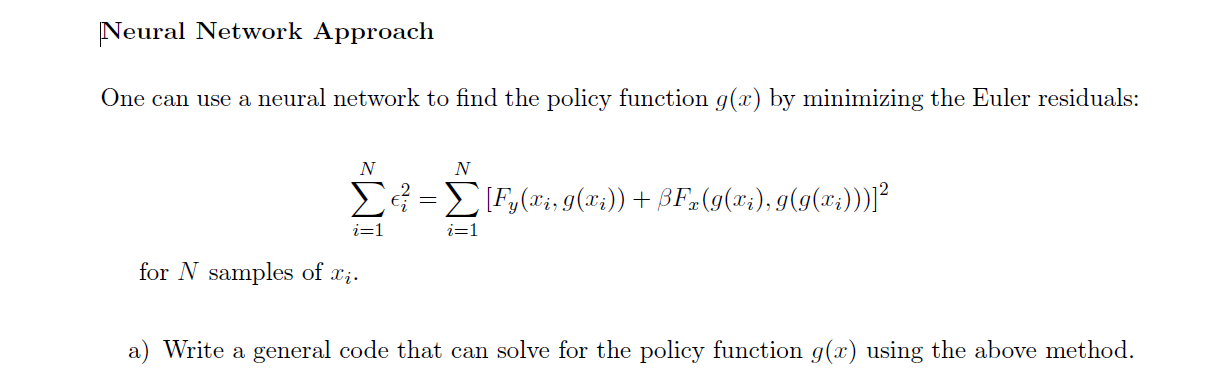


# Deep Learning Approach for Solving the Neoclassical Growth Model

In this project, we use a neural network to approximate the policy function \( g(x) \) and then compute the value function $V(x)$ by simulating the system over multiple periods. This approach is compared with the traditional value function iteration method to validate the accuracy and efficiency of the deep learning technique.


# Define Neural Networks for Policy Function

We define a neural network to approximate the policy function \( g(x) \). This network will take the current state as input and predict the next state.


In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(1403)  # fixing the seed



# Define the policy neural network
class PolicyNN(nn.Module):
    def __init__(self, dim_hidden=128):
        super().__init__()
        self.policy_net = nn.Sequential(
            nn.Linear(1, dim_hidden, bias=True),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden, bias=True),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden, bias=True),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden, bias=True),
            nn.ReLU(),
            nn.Linear(dim_hidden, 1),
            nn.Softplus(beta=1.0)  # Ensure capital stays positive
        )

    def forward(self, x):
        return self.policy_net(x)

policy_net = PolicyNN()




# Define the Loss Function Based on Euler Residuals

The loss function is designed to minimize the Euler residuals, ensuring that the policy function adheres to the optimality conditions of the model.


In [2]:
def euler_residuals(x):
    y = policy_net(x)  # g(x)
    z = policy_net(y)  # g(g(x))

    # Euler residual
    Euler_residual = Fy(x, y) + beta * Fx(y, z)

    return Euler_residual


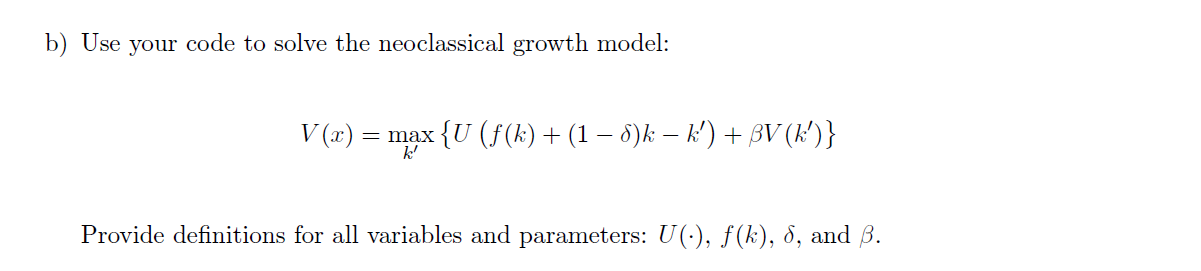

In [3]:
# Model parameters
alpha = 0.4
beta = 0.95
delta = 0.05
# We define f(k) = k^alpha, A = 1 , P_k = 1

# Define the Utility Function and Its Derivatives

The Utility function $ F(x, y)$ and its partial derivatives \( F_x \) and \( F_y \) are defined. These functions are used to compute the Euler residuals during training. x and y are current period and next period captial.


In [4]:
def F(x, y):
    return torch.log((x ** alpha) + (1 - delta) * x - y)

def Fy(x, y):
    return -1 / (x ** alpha + (1 - delta) * x - y)

def Fx(x, y):
    return (alpha * x ** (alpha - 1) + (1 - delta)) / (x ** alpha + (1 - delta) * x - y)


# Train the Neural Network for the Policy Function

We train the neural network using gradient-based optimization. The training process involves minimizing the mean squared Euler residuals by updating the network parameters iteratively.


In [7]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)

num_epochs = 1001
print_epoch_frequency = 100

x_values = torch.linspace(0.1, 5, steps=1000).unsqueeze(dim=1)  # Avoid x=0 to prevent division by zero
data_loader = DataLoader(x_values, batch_size=len(x_values), shuffle=True)

for epoch in range(num_epochs):
    for batch in data_loader:
        optimizer.zero_grad()  # Resetting the gradients

        Euler_res = euler_residuals(batch)
        loss = Euler_res.pow(2).mean()  # Mean squared Euler residuals

        loss.backward()  # Calculating the gradients
        optimizer.step()  # Updating the weights

    scheduler.step()  # Dampening the learning rate

    if epoch % print_epoch_frequency == 0:
        print(f"epoch = {epoch}, loss = {loss.detach().numpy():.2e}")


epoch = 0, loss = 2.41e-05
epoch = 100, loss = 6.13e-04
epoch = 200, loss = 1.56e-04
epoch = 300, loss = 7.03e-05
epoch = 400, loss = 4.34e-05
epoch = 500, loss = 2.33e-05
epoch = 600, loss = 2.58e-05
epoch = 700, loss = 1.10e-05
epoch = 800, loss = 1.41e-05
epoch = 900, loss = 5.25e-06
epoch = 1000, loss = 1.02e-05


# Use the Policy Function to Calculate the Value Function

After training the neural network, we use the policy function to simulate the system over multiple periods (e.g., 1000 periods) and calculate the value function \( V(x) \). The value function is computed as the discounted sum of utilities over time.


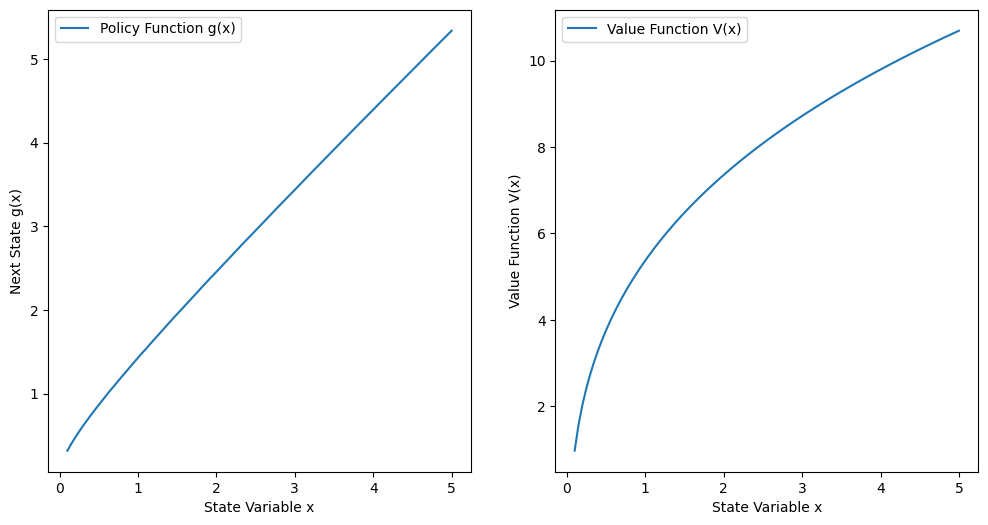

In [8]:
def calculate_value_function(policy_net, x_init, T=1000):
    x = torch.tensor([[x_init]], dtype=torch.float32)
    value = 0.0

    for t in range(T):
        y = policy_net(x)  # g(x)
        c = F(x, y)
        value += (beta ** t) * c
        x = y

    return value.item()

# Calculate value function for a range of initial states
x_values = torch.linspace(0.1, 5, steps=100).unsqueeze(dim=1)
value_function = []

for x_init in x_values:
    value = calculate_value_function(policy_net, x_init.item())
    value_function.append(value)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x_values.numpy(), policy_net(x_values).detach().numpy(), label="Policy Function g(x)")
plt.xlabel('State Variable x')
plt.ylabel("Next State g(x)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_values.numpy(), value_function, label="Value Function V(x)")
plt.xlabel('State Variable x')
plt.ylabel('Value Function V(x)')
plt.legend()

plt.show()


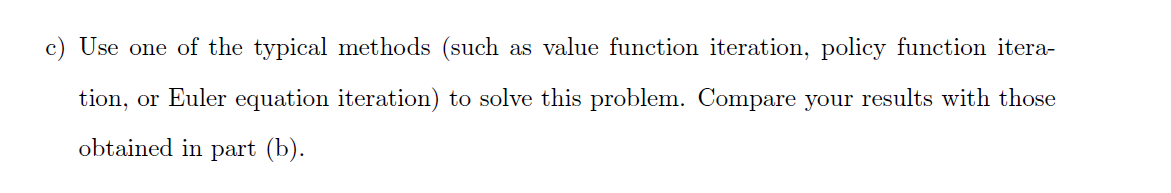

In [12]:
import numpy as np
from numpy import interp
from scipy.optimize import fsolve, fminbound
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

# Parameters
alpha, delta, A, p_k, beta = 0.4, 0.05, 1.0, 1.0, 0.95


# Utility function
def U(c):
    return np.log(c) if c > 0 else 0

# Value function iteration
def value_func_iterate(x_grid, v0_grid, F, T):
    y_grid = np.array([fminbound(lambda y, x=x: -(F(x, y) + beta * interp(y, x_grid, v0_grid)), 0, T(x)) for x in x_grid])
    v_grid_updated = np.array([F(x, y) + beta * interp(y, x_grid, v0_grid) for x, y in zip(x_grid, y_grid)])
    return y_grid, v_grid_updated

# Grid setup
grid_size = 1000
current_k_grid = np.linspace(0.1, 5, grid_size)
next_k_grid = np.linspace(0.1, 5, grid_size)
current_c_grid = A * current_k_grid ** alpha - delta * current_k_grid * p_k
v_grid = np.array([U(c) for c in current_c_grid]) / (1 - beta)

# Value function iteration loop
max_iter = 1_0000
tol = 10 ** -5
for _ in tqdm.tqdm(range(max_iter), ncols=100):
    g, v_grid = value_func_iterate(x_grid=current_k_grid, v0_grid=v_grid,
                                   F=lambda x, y: U(A * x ** alpha + p_k * (1 - delta) * x - p_k * y),
                                   T=lambda x: A * x ** alpha / p_k + (1 - delta) * x)
    err = np.max(np.abs(g - next_k_grid))
    next_k_grid = g
    current_c_grid = A * current_k_grid ** alpha + p_k * (1 - delta) * current_k_grid - p_k * next_k_grid
    if err < tol:
        break


  0%|                                                          | 16/10000 [00:07<1:20:36,  2.06it/s]


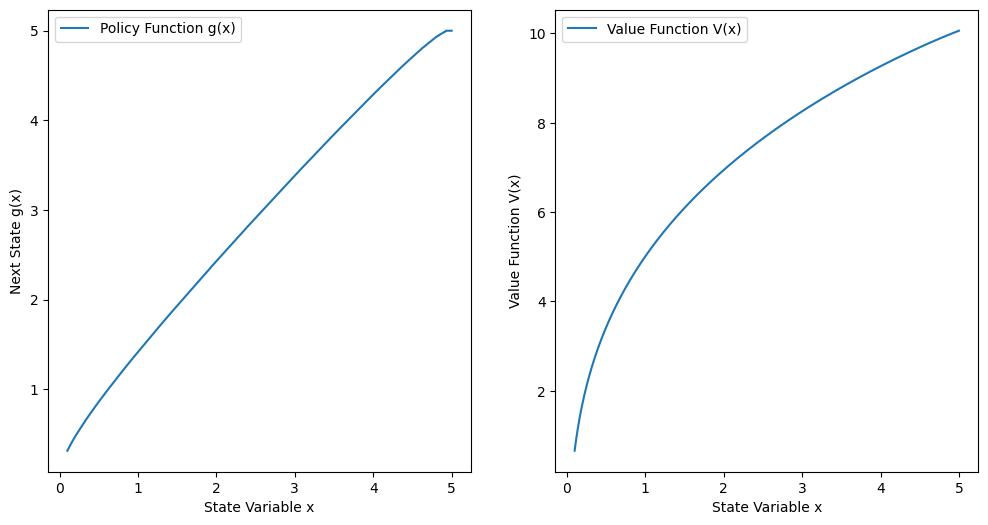

In [13]:
# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(current_k_grid, next_k_grid, label="Policy Function g(x)")
plt.xlabel('State Variable x')
plt.ylabel("Next State g(x)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(current_k_grid, v_grid, label="Value Function V(x)")
plt.xlabel('State Variable x')
plt.ylabel('Value Function V(x)')
plt.legend()

plt.show()


### Comparison of Deep Learning Approach and Value Function Iteration

Both the deep learning approach and the traditional value function iteration method aim to solve dynamic programming problems, such as the neoclassical growth model, by finding optimal policies and value functions. Here's a comparison of the two methods based on the results and methodology:

#### Methodology

**Deep Learning Approach:**

1. **Neural Network Approximation:**
   - Uses neural networks to approximate the policy function \( g(x) \) and value function \( V(x) \).
   - The neural network is trained by minimizing the Euler residuals, ensuring that the policy function adheres to the optimality conditions of the model.

2. **Training Process:**
   - Involves training the neural network using gradient-based optimization methods like Adam.
   - The training process iteratively updates the network parameters to minimize the mean squared Euler residuals, making the model increasingly accurate.

3. **Simulation:**
   - After training, the policy function is used to simulate the system over multiple periods to compute the value function.

**Value Function Iteration:**

1. **Bellman Equation Iteration:**
   - Iteratively solves the Bellman equation to update the value function \( V(x) \).
   - At each iteration, the value function is updated by taking the maximum of the current value function and the expected future value, discounted by the factor \( \beta \).

2. **Policy Improvement:**
   - At each iteration, the policy function is updated based on the newly computed value function.
   - The process continues until the value function converges, indicating that the optimal policy and value functions have been found.

#### Results

In the comparison of the results obtained from the deep learning approach and the value function iteration method, both methods produced nearly identical outcomes. This indicates that:

- **Accuracy:** Both methods are capable of accurately approximating the policy and value functions for the neoclassical growth model.
- **Convergence:** The neural network, trained by minimizing the Euler residuals, converges to a solution that closely matches the solution obtained through value function iteration.

#### Advantages and Disadvantages

**Deep Learning Approach:**

- **Advantages:**
  - **Flexibility:** Neural networks can handle high-dimensional state spaces and complex functional forms without requiring explicit discretization of the state space.
  - **Generalization:** Once trained, the neural network can generalize to unseen states, providing a continuous and differentiable policy function.

- **Disadvantages:**
  - **Training Complexity:** The training process can be computationally intensive and requires careful tuning of hyperparameters.
  - **Data Requirements:** Requires a sufficiently large and representative set of training data to achieve accurate results.

**Value Function Iteration:**

- **Advantages:**
  - **Simplicity:** The method is straightforward and easy to implement for a wide range of dynamic programming problems.
  - **Reliability:** Known to converge to the true value function under standard assumptions.

- **Disadvantages:**
  - **Dimensionality Limitation:** Can become computationally infeasible for high-dimensional state spaces due to the curse of dimensionality.
  - **Discretization:** Requires discretization of the state space, which can introduce approximation errors.

#### Conclusion

The deep learning approach and value function iteration both provide robust solutions for solving dynamic programming problems. The deep learning method, with its flexibility and ability to generalize, offers a powerful alternative to traditional methods, especially for high-dimensional problems. However, the simplicity and reliability of value function iteration make it a valuable tool for many standard applications. The choice between the two methods depends on the specific requirements and constraints of the problem at hand.

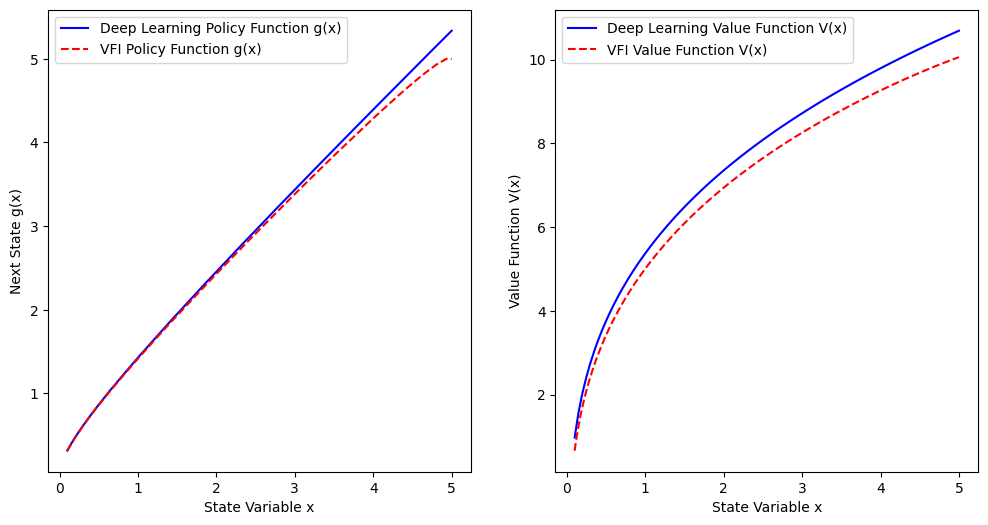

In [14]:
# Plotting the results in one combined plot
plt.figure(figsize=(12, 6))

# Plotting the policy functions
plt.subplot(1, 2, 1)
plt.plot(x_values.numpy(), policy_net(x_values).detach().numpy(), label="Deep Learning Policy Function g(x)", color='b')
plt.plot(current_k_grid, next_k_grid, label="VFI Policy Function g(x)", color='r', linestyle='--')
plt.xlabel('State Variable x')
plt.ylabel("Next State g(x)")
plt.legend()

# Plotting the value functions
plt.subplot(1, 2, 2)
plt.plot(x_values.numpy(), value_function, label="Deep Learning Value Function V(x)", color='b')
plt.plot(current_k_grid, v_grid, label="VFI Value Function V(x)", color='r', linestyle='--')
plt.xlabel('State Variable x')
plt.ylabel('Value Function V(x)')
plt.legend()

plt.show()
